-------------------------------------------------------------------
**TD DSA 2021 de Antoine Ly   -   rapport de Fabien Faivre**
-------------------------     -------------------------------------

# Description du projet et de la stratégie a priori

L'approche déployée consiste à analyser des tweets en langue anglaise et de prédire les sentiments qu'ils portent : `{negative: -1, neutral: 0, positive: 1}`

Dans cet exercice, la langue anglaise est un facteur facilitant dans la mesure où beaucoup de modèles préentrainés existent dans cette langue.

La difficulté dans cet exercice provient de sa source : les tweets.
Les approches classiques reposent sur :
- le passage en minuscule, or dans les tweets, l'utilisation de mots en **majuscules** est un marqueur d'une **émotion forte**
- l'utilisation de structures linguisitiques relativement correctes augmentées par la lemmatisation / tokenisation. 
Or, les mots utilisés dans les tweets font l'objet de nombreuses **fautes d'orthographes ou d'abbréviations** (ex `thx`)
- les marqueurs de ponctuation sont usuellement retirés, or ici, ils peuvent être utilisés comme **smiley** `;-)` ou pour marquer une **émotion forte** `!!!`
- l'**humour** et les **euphémismes** sont très présents sur tweeter, or les modèles ont beaucoup de mal à distinguer ces cas qui nécessitent une compréhension contextuelle.

En complément au sujet du TD lui-même, celui-ci a été l'occasion de monter en compétence avec les (je l'espère) bonnes pratiques de codage et l'utilisation de techniques de MLOps.

Le code de ce projet a été organisé en s'appuyant sur le framework open source [**orbyter**](https://github.com/manifoldai/orbyter-cookiecutter) de la société [Manifold.ai](https://www.manifold.ai/project-orbyter). Ce framework pousse à la standardisation de la structure du code, via l'utilisation de `cookiecutter` et promeut un développement dans un environnement dockerisé dès le départ : 

![structure](https://www.manifold.ai/hubfs/Torus.png) 

La logique de développement pronée est disponible [ici](https://cdn2.hubspot.net/hubfs/4584542/Conference%20Slides/2019StrataNY_EfficientMLengineering.pdf)

Plusieurs modifications ont dû être apportées aux paramètres du `docker-compose` pour permettre un accès aux ressources GPU depuis le docker.

Le code a été versionné et est disponible ici [github](https://github.com/Fabien-DS/DSA_Sentiment)

# Setup

Inspiration : https://medium.com/deepdatascience/feature-extraction-from-text-text-data-preprocessing-594b11af19f5

In [3]:
!pip install textblob

In [4]:
!pip install emot

In [157]:
!pip install wordcloud

     |████████████████████████████████| 371 kB 16.0 MB/s eta 0:00:01


In [301]:
#Temps et fichiers
import os
import warnings
import time
from datetime import timedelta

#Manipulation de données
import pandas as pd
import numpy as np

# Text
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.util import ngrams

from textblob import TextBlob
import string
import re
import spacy 
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

#Modélisation
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV# the keys can be accessed with final_pipeline.get_params().keys()
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier


#Evaluation
from sklearn.metrics import f1_score, confusion_matrix


#Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

#Tracking d'expérience
import mlflow
import mlflow.sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [159]:
!pip freeze > /mnt/docker/requirements.txt

## Utilisation du package

In [7]:
#Cette cellule permet d'appeler la version packagée du projet et d'en assurer le reload avant appel des fonctions
%load_ext autoreload
%autoreload 2

In [8]:
from dsa_sentiment.scripts.make_dataset import load_data
from dsa_sentiment.scripts.evaluate import eval_metrics
from dsa_sentiment.scripts.make_dataset import Preprocess_StrLower, Preprocess_transform_target

## Configuration de l'experiment MLFlow

In [9]:
mlflow.tracking.get_tracking_uri()

'/mnt/experiments'

## Chargement des données

In [10]:
!pwd

/mnt/notebooks/EDA


In [85]:
data_folder = os.path.join('/mnt', 'data', 'raw')
all_raw_files = [os.path.join(data_folder, fname)
                    for fname in os.listdir(data_folder)]
all_raw_files

['/mnt/data/raw/sample_submission.csv',
 '/mnt/data/raw/test.csv',
 '/mnt/data/raw/train.csv']

In [86]:
random_state=42

Il n'est pas possible de faire de l'imputation comme avec des champs numérique. Il convient donc de supprimer les tweets vides (`dropNA=True`).

En complément, il est decidé de réserver 30% du jeu d'entrainnement pour créer un jeu de validation.

In [100]:
X_train, y_train, X_val, y_val = load_data(all_raw_files[2], split=True, test_size=0.3, random_state=random_state, dropNA=True)

In [101]:
X_train.head()

,textID,text,selected_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD
2,088c60f138,my boss is bullying me...,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,"


In [102]:
print(f'le jeu d\'entraînement initial contient', X_train.shape[0] + X_val.shape[0], 'lignes')

le jeu d'entraînement initial contient 27480 lignes


In [103]:
y_train.head()

,sentiment
0,neutral
1,negative
2,negative
3,negative
4,negative


In [104]:
X_test, y_test = load_data(all_raw_files[1], split=False, random_state=random_state, dropNA=True)

In [105]:
X_test.head()

,textID,text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!


In [106]:
print(f'le jeu de test contient', X_test.shape[0] , 'lignes')

le jeu de test contient 3534 lignes


## Transformation initiales des données

Cette partie vise uniquement à sélectionner les colonnes dont nous nous servirons et à transcoder la cible au format souhaité.

In [107]:
# Dans ce projet on ne se servira que du champs `text`. On cherche toutefois à conserver le format pandas DataFrame
X_train = X_train[['text']]
X_val = X_val[['text']]
X_test = X_test[['text']]

In [108]:
X_train.head()

,text
0,"I`d have responded, if I were going"
1,Sooo SAD I will miss you here in San Diego!!!
2,my boss is bullying me...
3,what interview! leave me alone
4,"Sons of ****, why couldn`t they put them on t..."


On commence par transformer les cibles pour se conformer aux instructions

# EDA

On commence par nalyser l'équilibre des différentes classes de sentiments

In [122]:
df = pd.concat([X_train, y_train], axis=1)
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


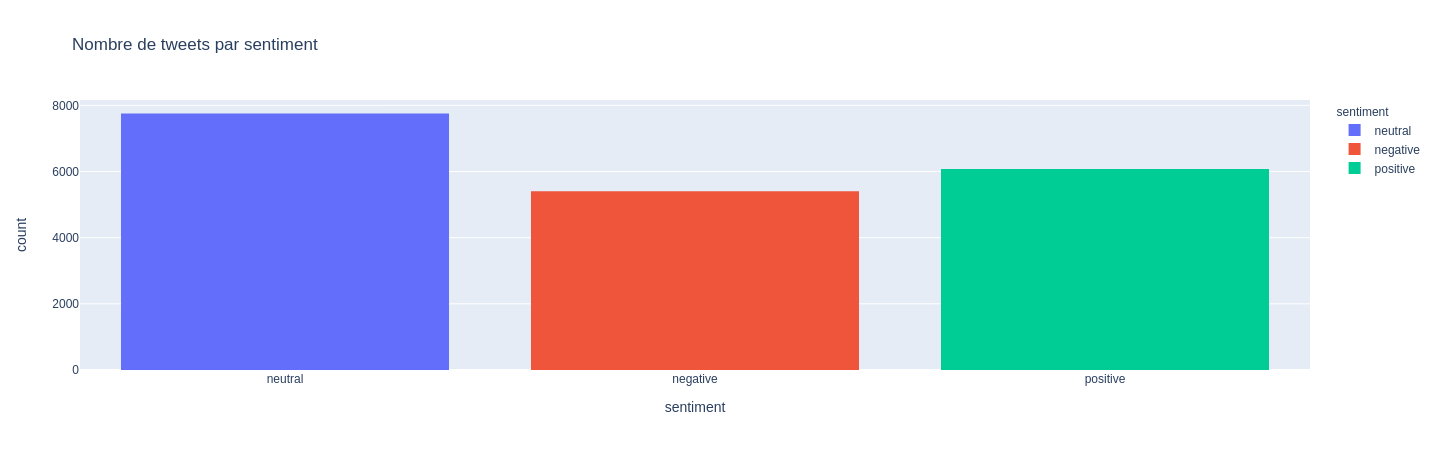

In [124]:
fig = px.histogram(df, x="sentiment", color="sentiment", title = 'Nombre de tweets par sentiment')
fig.show()

Il existe un léger déséquilibre dans les classes en faveur des sentiments `neutral`

In [238]:
def create_corpus(text_series):
    text = text_series.apply(lambda x : x.split())
    text = sum(text, [])
    return text
    

In [239]:
positive_text = create_corpus(df['text'][df['sentiment']=='positive'])
negative_text = create_corpus(df['text'][df['sentiment']=='negative'])
neutral_text = create_corpus(df['text'][df['sentiment']=='neutral'])


In [333]:
def plot_freq_dist(text_corpus, nb=30, ngram=1, title=''):
    '''
    Plot the most common words
    
    inputs:
        text_corpus : a corpus of words
        nb : number of words to plot
        title : graph title
    
    returns:
        nothing, plots the graph
    
    '''
    # Plot the most common words in positive sentiment
    freq_pos=Counter(ngrams(create_corpus(pd.Series(text_corpus)),ngram))
    pos_df = pd.DataFrame({
        "words":[' '.join(items) for items in list(freq_pos.keys())],
        "Count":list(freq_pos.values())
    })
    common_pos= pos_df.nlargest(columns="Count", n=30)

    fig = px.bar(common_pos, x="words", y="Count", labels={"words": "Words", "Count":"Frequency"}, title=title)
    fig.show();

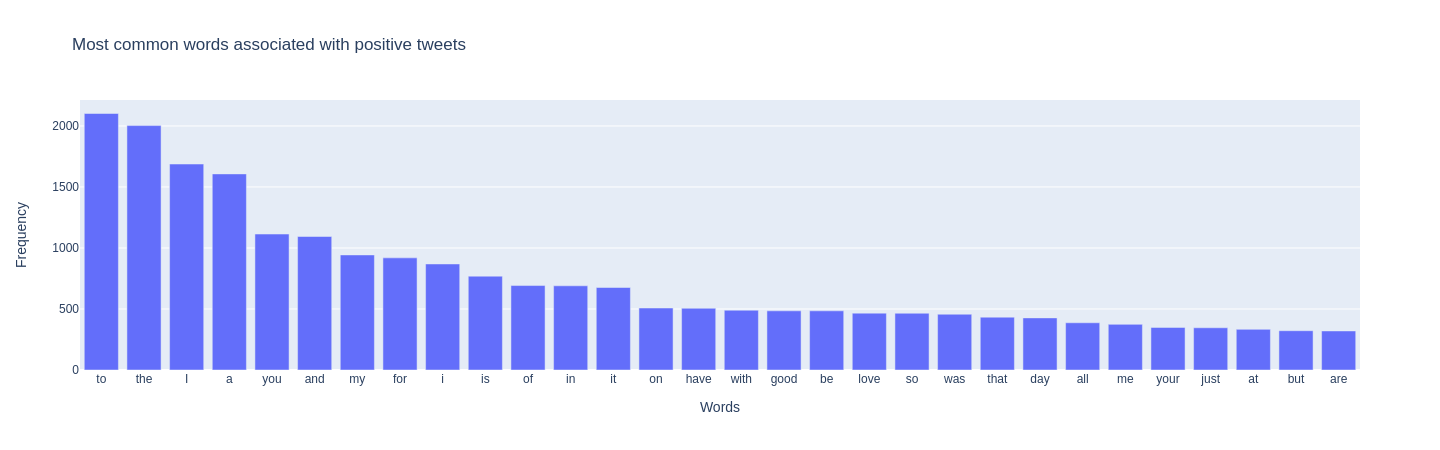

In [334]:
plot_freq_dist(positive_text, title = 'Most common words associated with positive tweets')

source [preprocess](https://www.kaggle.com/stoicstatic/twitter-sentiment-analysis-for-beginners)

In [549]:
def preprocess_text(text_series, 
                    apply_lemmatizer=True,
                    apply_lowercase=True,
                    apply_url_standerdisation=True,
                    apply_user_standerdisation=True,
                    apply_emoticon_to_words=True,
                    apply_stopwords_removal=True,
                    apply_shortwords_removal=True,
                    apply_non_alphabetical_removal=True,
                    apply_only_2_consecutive_charac=True
                   
                   ):
    '''
    Main preprocess function
    
    inputs:
        text_series : a pandas Series object with text to preprocess
    
    outputs:
        a preprocessed pandas Series object
    '''
    
    processedText = []
    
    if apply_lemmatizer:
        # Create Lemmatizer and Stemmer.
        wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = r"[^(\w|\*|(!){2}|#)]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in text_series:
        
        if apply_lowercase:
            tweet = tweet.lower()
        
        if apply_url_standerdisation:
            # Replace all URls with 'URL'
            tweet = re.sub(urlPattern,' URL',tweet)
        
        if apply_user_standerdisation:
            # Replace @USERNAME to 'USER'.
            tweet = re.sub(userPattern,' USER', tweet)  
        
        if apply_emoticon_to_words:
            # Replace all emojis.
            for emo in EMOTICONS:
                #refactor outputs so that we come up with a single word when/if text spliting afterwards
                val = "_".join(EMOTICONS[emo].replace(",","").split())
                val='EMO_'+val
                tweet = tweet.replace(emo, ' '+val+' ')        
      
        if apply_only_2_consecutive_charac:
            # Replace 3 or more consecutive letters by 2 letter.
            tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        if apply_non_alphabetical_removal:
            # Replace all non alphabets.
            tweet = re.sub(alphaPattern, " ", tweet)
        

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if apply_stopwords_removal: 
                if word in stopwords.words('english'):
                    word=''
            else:
                word=word
            #if word not in stopwordlist:
            if apply_shortwords_removal:
                if len(word)<=1:
                    word=''
            else:
                word=word
            # Lemmatizing the word.
            if apply_lemmatizer:
                word = wordLemm.lemmatize(word)
            else:
                word=word
            
            tweetwords += (word+' ')

        processedText.append(tweetwords)
        
    return pd.Series(processedText)


In [550]:
positive_text_2 = preprocess_text(df['text'][df['sentiment']=='positive'], apply_lemmatizer=False, apply_non_alphabetical_removal=True)

In [551]:
neutral_text_2 = preprocess_text(df['text'][df['sentiment']=='neutral'], apply_lemmatizer=False, apply_non_alphabetical_removal=True)

In [552]:
negative_text_2 = preprocess_text(df['text'][df['sentiment']=='negative'], apply_lemmatizer=False, apply_non_alphabetical_removal=True)

In [520]:
def plotWc(text, stopwords=None, title=''):
    wc = WordCloud(
            stopwords=stopwords,
            width=800,
            height=400,
            max_words=1000,
            random_state=44,
            background_color="white",
            collocations=False
    ).generate(text)
    
    plt.figure(figsize = (10,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

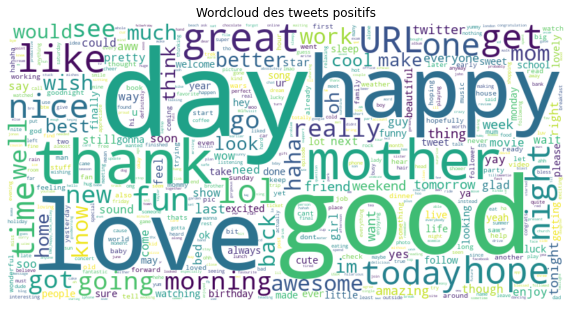

In [521]:
plotWc(" ".join(positive_text_2), stopwords=stopwords.words('english'), title = "Wordcloud des tweets positifs")

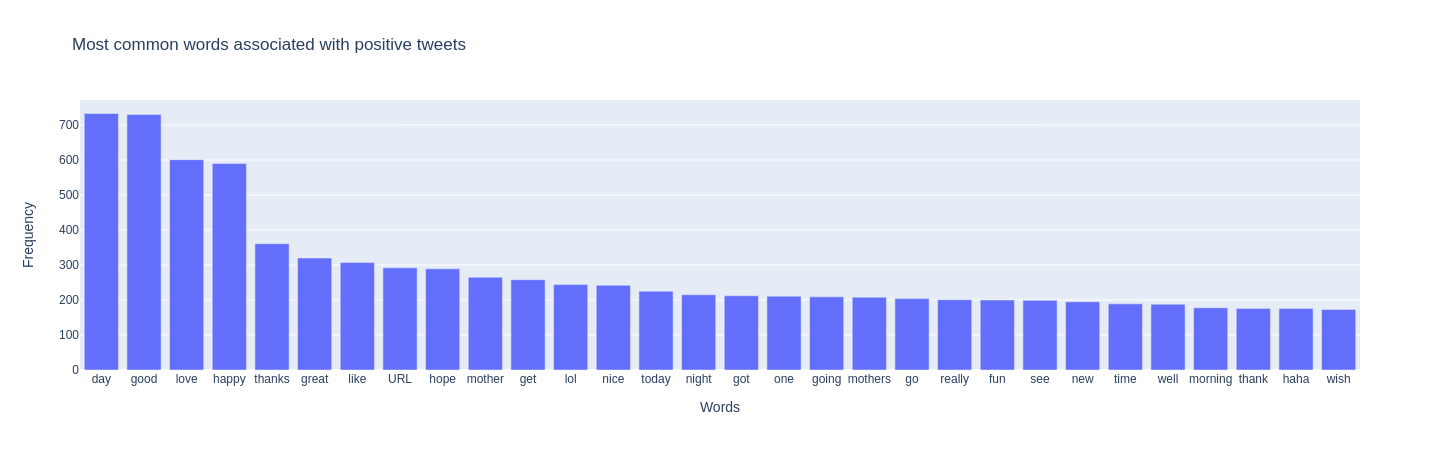

In [522]:
plot_freq_dist(create_corpus(positive_text_2), title = 'Most common words associated with positive tweets')

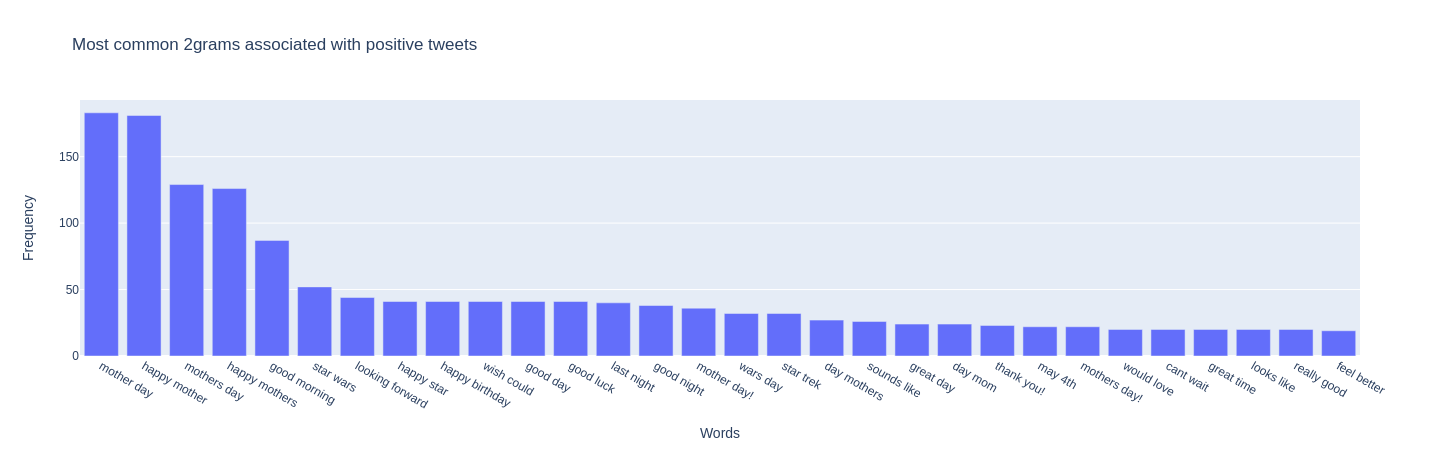

In [523]:
plot_freq_dist(create_corpus(positive_text_2), ngram=2, title = 'Most common 2grams associated with positive tweets')

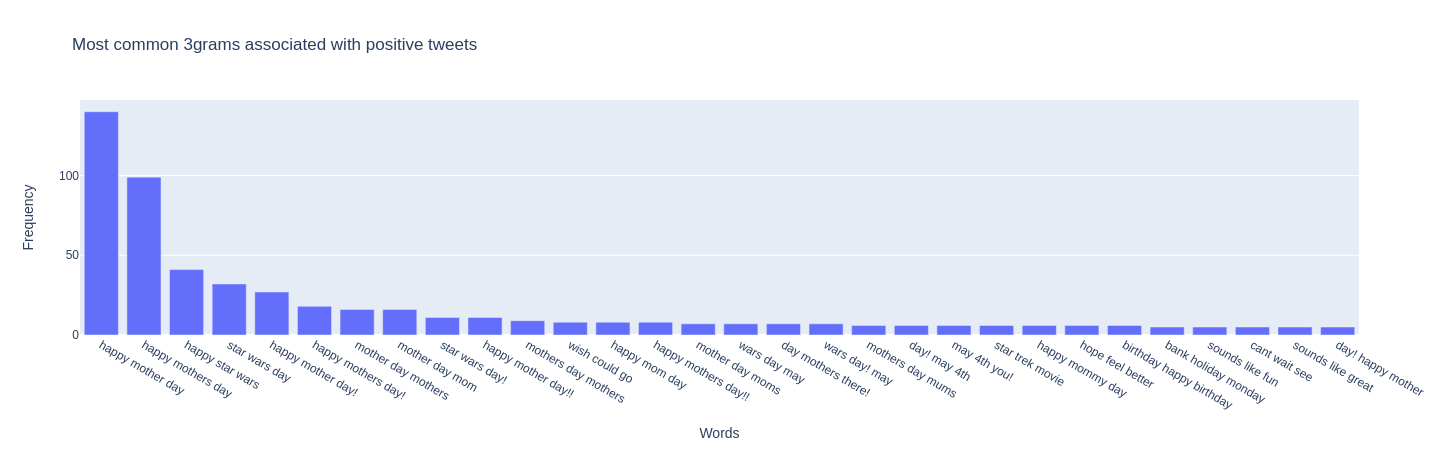

In [553]:
plot_freq_dist(create_corpus(positive_text_2), ngram=3, title = 'Most common 3grams associated with positive tweets')

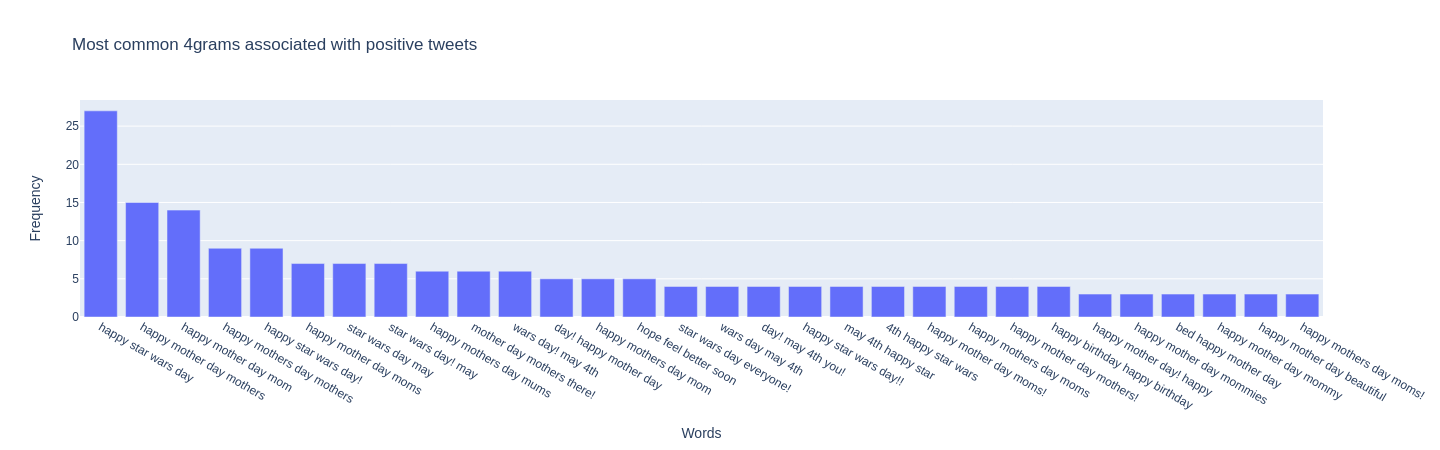

In [554]:
plot_freq_dist(create_corpus(positive_text_2), ngram=4, title = 'Most common 4grams associated with positive tweets')

[**insight**] : Une grande majorité de tweets positifs se rapportent soit à la fête des mère, soit au 4 Mai du fait du jeu de mot avec Star Wars...

![StarWars](https://upload.wikimedia.org/wikipedia/fr/c/ca/LogoSW4th.png)

Cette spécificité sera surement exploitée par les modèles comme un marqueur probable de tweets positifs.

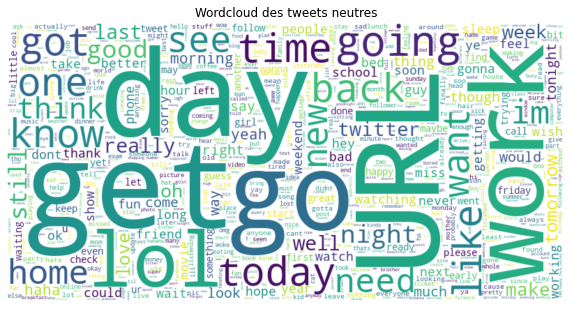

In [526]:
plotWc(" ".join(neutral_text_2), stopwords=stopwords.words('english'), title = "Wordcloud des tweets neutres")

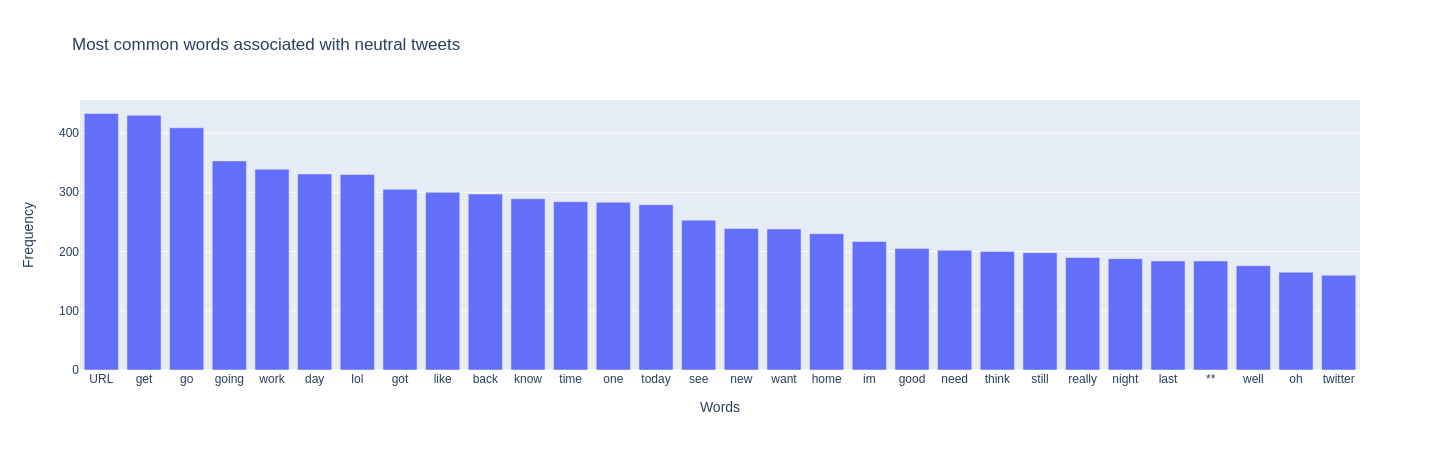

In [527]:
plot_freq_dist(create_corpus(neutral_text_2), title = 'Most common words associated with neutral tweets')

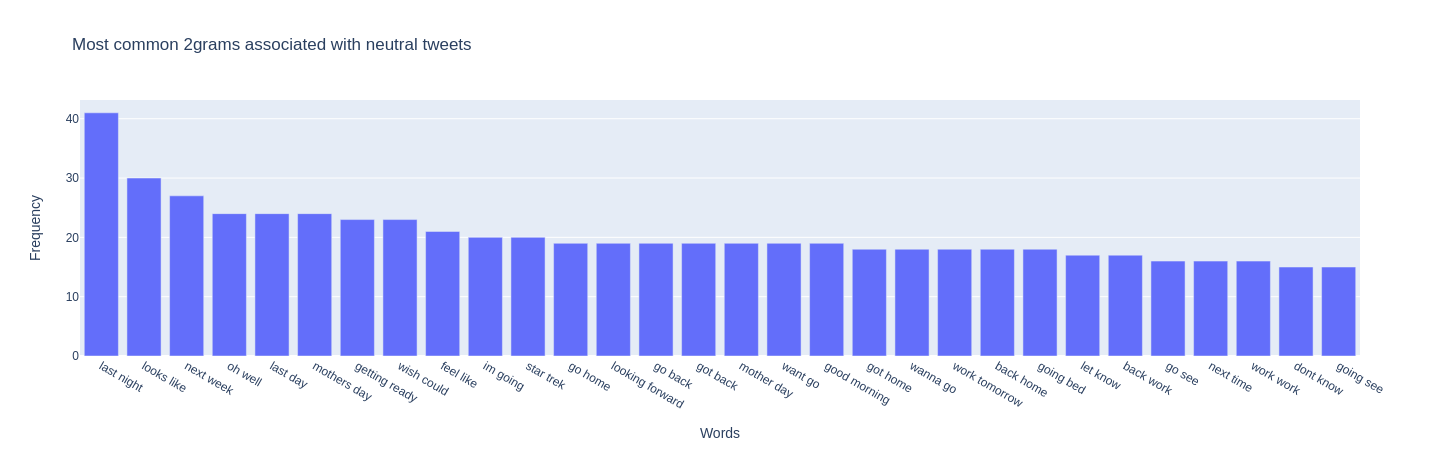

In [528]:
plot_freq_dist(create_corpus(neutral_text_2), ngram=2, title = 'Most common 2grams associated with neutral tweets')

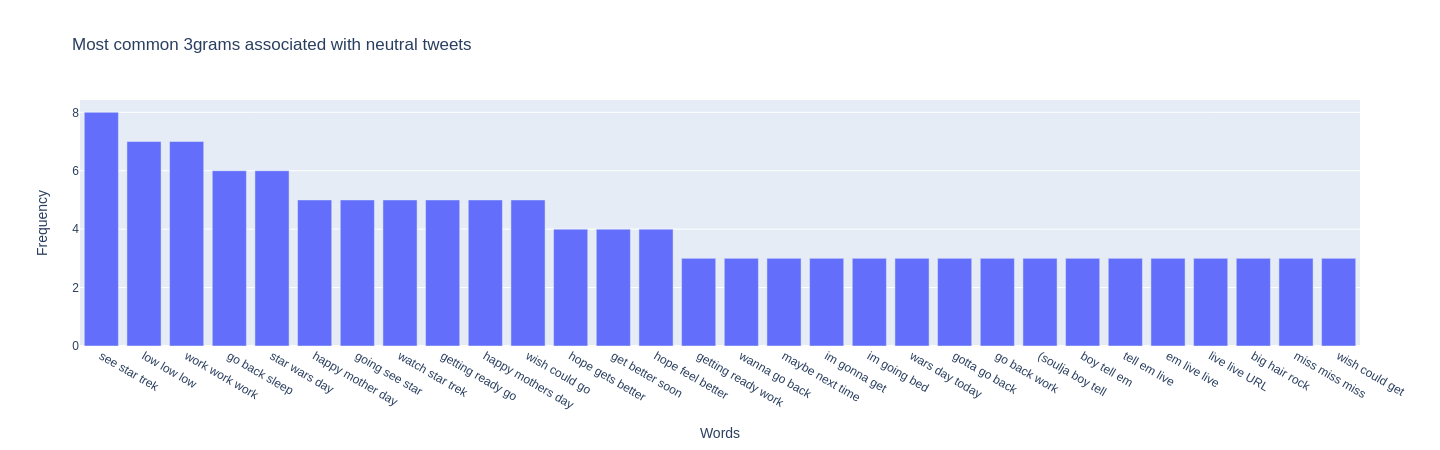

In [529]:
plot_freq_dist(create_corpus(neutral_text_2), ngram=3, title = 'Most common 3grams associated with neutral tweets')

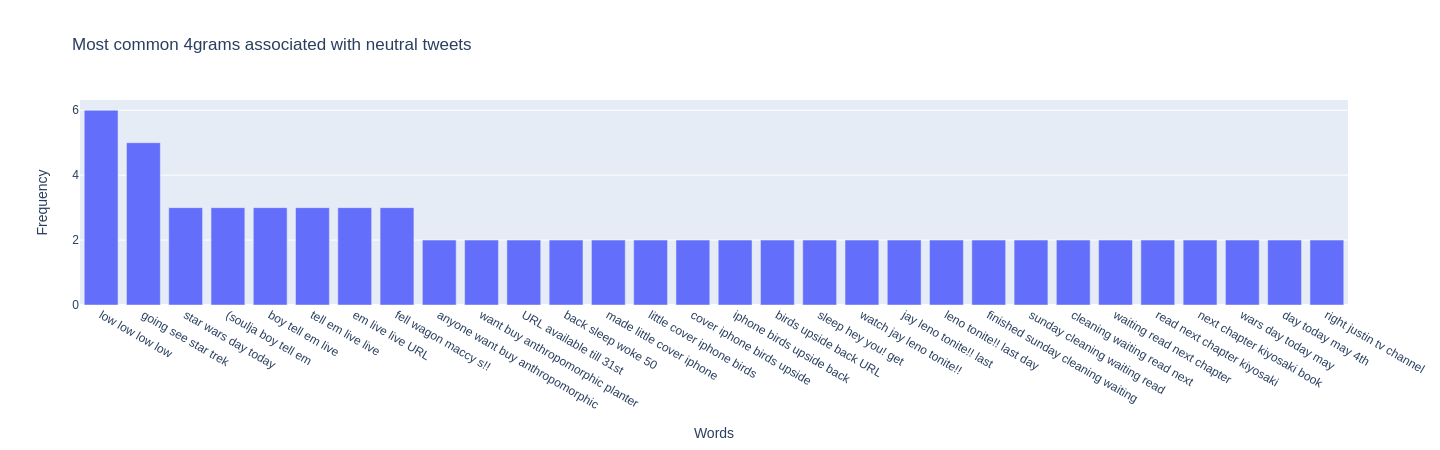

In [530]:
plot_freq_dist(create_corpus(neutral_text_2), ngram=4, title = 'Most common 4grams associated with neutral tweets')

[**insight**] : On voit une source de confusion arriver avec les twwets neutres dans la mesure où une proportion significative de ceux-ci se rapportent aussi à la fête des mères et star wars. 

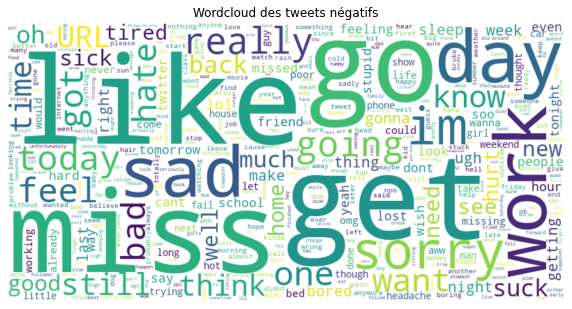

In [531]:
plotWc(" ".join(negative_text_2), stopwords=stopwords.words('english'), title = "Wordcloud des tweets négatifs")

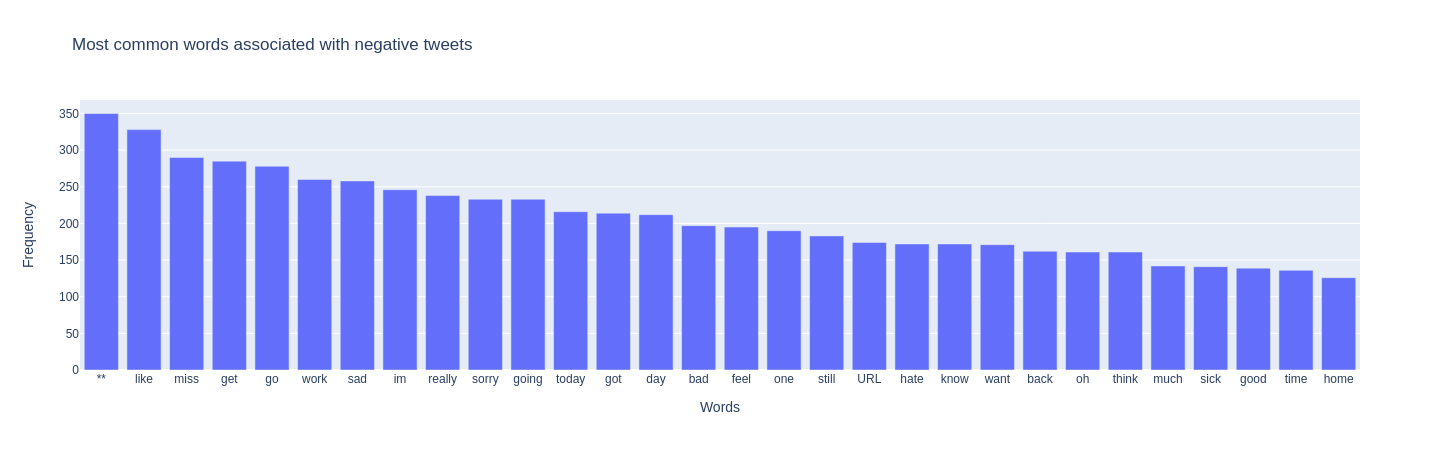

In [532]:
plot_freq_dist(create_corpus(negative_text_2), title = 'Most common words associated with negative tweets')

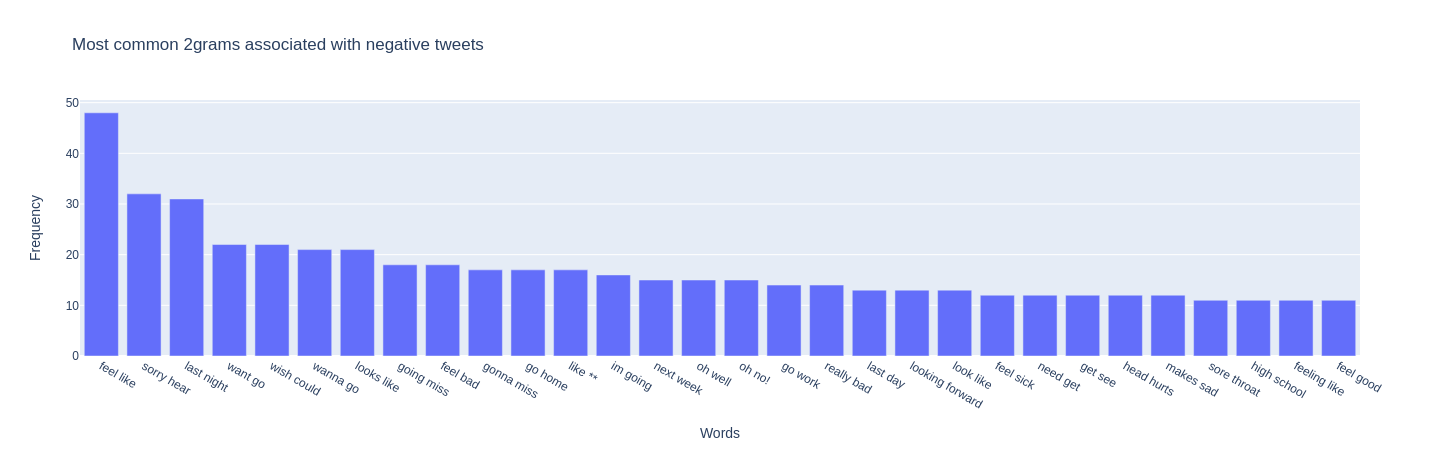

In [533]:
plot_freq_dist(create_corpus(negative_text_2), ngram=2, title = 'Most common 2grams associated with negative tweets')

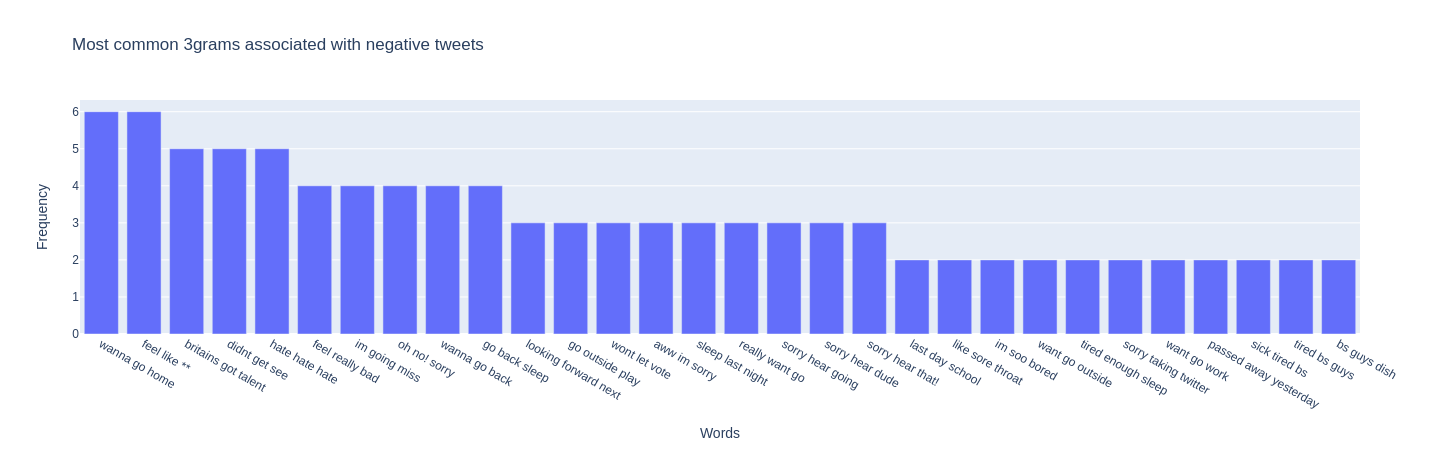

In [534]:
plot_freq_dist(create_corpus(negative_text_2), ngram=3, title = 'Most common 3grams associated with negative tweets')

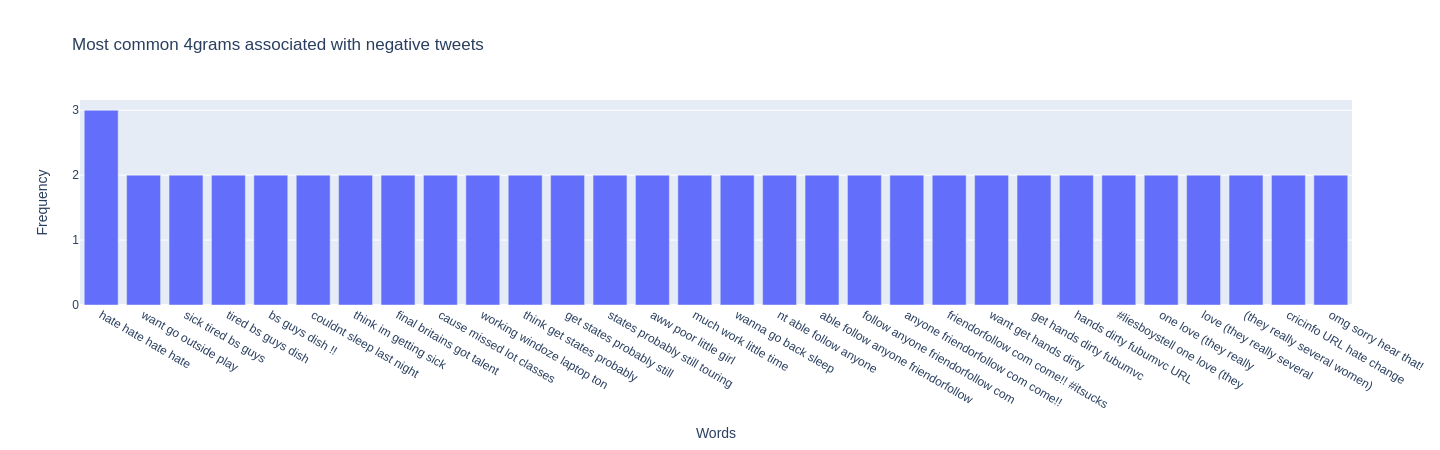

In [535]:
plot_freq_dist(create_corpus(negative_text_2), ngram=4, title = 'Most common 4grams associated with negative tweets')

[**insight**] : on observe l'utilisation de mots autocensurés (' ** ') et de mots très chargés ('hate')

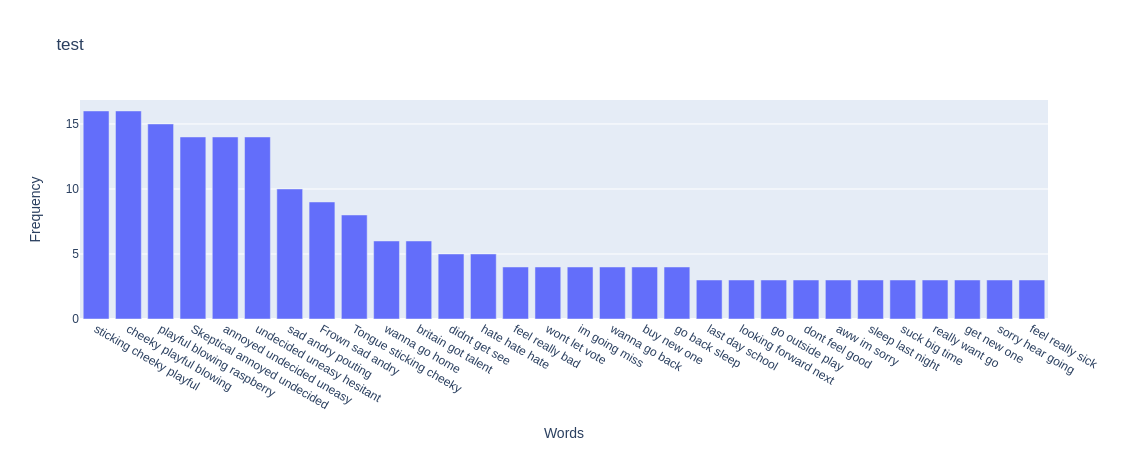

In [390]:
fig = px.bar(common_pos, x="words", y="Count", labels={"words": "Words", "Count":"Frequency"}, title='test')
fig.show();

In [411]:
def list_words_with(text_series, search='', nb=30):
    searchPattern   = f"\w*{search}\w*"
    
    cnt = Counter()
    
    for tweet in text_series:
        # Replace all URls with 'URL'
        tweet = re.findall(searchPattern,tweet)
        for word in tweet:
            cnt[word] += 1
    return cnt.most_common(nb)
    

In [515]:
#liste des mots incluant auto-censure **
list_words_with(negative_text_2, search='\*{2}')

[('**', 375),
 ('bl**y', 1),
 ('_megan_**', 1),
 ('**i', 1),
 ('_da_**', 1),
 ('j**i', 1),
 ('_**', 1),
 ('f**', 1)]

In [512]:
#nombre d'utilisateurs
list_words_with(negative_text_2, search='USER')

[('USER', 18)]

In [511]:
#nombre d'URLs
list_words_with(negative_text_2, search='URL')

[('URL', 174)]

In [510]:
#liste des émojis
list_words_with(negative_text_2, search='EMO\w+')

[('EMO_Happy_face_smiley', 17),
 ('EMO_Tongue_sticking_out_cheeky_playful_or_blowing_a_raspberry', 16),
 ('EMO_Skeptical_annoyed_undecided_uneasy_or_hesitant', 14),
 ('EMO_Frown_sad_andry_or_pouting', 10),
 ('EMO_Surprise', 9),
 ('EMO_Sealed_lips_or_wearing_braces_or_tongue', 1),
 ('EMO_Embarrassed_or_blushing', 1),
 ('EMO_Shock', 1),
 ('EMO_Sad_or_Crying', 1)]

In [508]:
#les mots qui incluents !!
list_words_with(negative_text_2, search='!!')

[('!!', 51),
 ('me!!', 13),
 ('sucks!!', 7),
 ('you!!', 6),
 ('it!!', 6),
 ('again!!', 5),
 ('today!!', 5),
 ('now!!', 4),
 ('hurts!!', 4),
 ('up!!', 4),
 ('starving!!', 3),
 ('bed!!', 3),
 ('time!!', 3),
 ('ugh!!', 3),
 ('that!!', 3),
 ('sleep!!', 3),
 ('home!!', 3),
 ('noo!!', 3),
 ('sorry!!', 3),
 ('omg!!', 3),
 ('blows!!', 2),
 ('night!!', 2),
 ('top!!', 2),
 ('no!!', 2),
 ('there!!', 2),
 ('ughh!!', 2),
 ('badly!!', 2),
 ('house!!', 2),
 ('guys!!', 2),
 ('working!!', 2)]

In [507]:
#les tweets complets qui incluent 'bs' (apparaît dans les 4grams)
list_words_with(negative_text_2, search='[\w ]* bs [\w ]*')

[('soo   kinda  sick  tired   bs  guys dish  ', 1),
 ('soo   kind  sick  tired   bs  guys dish  ', 1),
 ('fudge  bs   whole paper  tired ugh  hate school time  sleep', 1)]

In [506]:
#listing des mots clefs
list_words_with(negative_text_2, search='#[(\w*|\d*)]+')

[('#bgt', 8),
 ('#fb', 4),
 ('#itsucks', 3),
 ('#fail', 3),
 ('#fieldnotes', 2),
 ('#sad', 2),
 ('#beatwittyparty', 2),
 ('#fixreplies', 2),
 ('#liesboystell', 2),
 ('#hunchback', 1),
 ('#screengrab09', 1),
 ('#obs', 1),
 ('#comet09', 1),
 ('#tcot', 1),
 ('#antiboyle', 1),
 ('#2923848932', 1),
 ('#linux', 1),
 ('#ubuntu', 1),
 ('#nontweetinggirlfriend', 1),
 ('#brandwkshop', 1),
 ('#followfriday', 1),
 ('#beta1', 1),
 ('#livescribe', 1),
 ('#luto', 1),
 ('#rip', 1),
 ('#rda2009cla', 1),
 ('#britainsgottalent', 1),
 ('#gm', 1),
 ('#1', 1),
 ('#followfridays', 1)]

In [202]:
def user_names(text_list):
    cnt = Counter()
    for text in text_list:
        for word in text.split():
            if word.startswith('@'):
                cnt[word] += 1
    return cnt
    

In [224]:
user_names(positive_text)

Counter({'@_agressiva23': 1,
         '@_TWEE': 1,
         '@': 44,
         '@_Mintyfresh': 1,
         '@_josh_thomas': 1,
         '@_catchfire': 1,
         '@_elj': 1,
         '@_Flik_': 1,
         '@_writersblock_': 1,
         '@_chloe': 1,
         '@_anh': 1,
         '@_mamalaura': 1,
         '@_careerbuilder_': 1,
         '@_Bella_Cullen13': 1,
         '@>--->--->---': 1})

In [225]:
user_names(positive_text_2)

Counter({'@': 44})

In [226]:
user_names(negative_text_2)

Counter({'@': 42})

In [227]:
user_names(neutral_text_2)

Counter({'@': 60})

# Preprocessing

Parmi les éléments propres aux tweets qui peuvent avoir un impact sur la suite on compte :

 - les mots clefs marqués par un `#`
 - les noms d'utilisateurs commençant par un `@`
 - les valeurs numériques mentionnées
 - les nombre de mots en MAJUSCULES

## Préalable : transformation des sorties

In [22]:
y_train = Preprocess_transform_target(y_train, columns_to_process=['sentiment'])
y_train.head()

,sentiment
0,0
1,-1
2,-1
3,-1
4,-1


In [23]:
y_val = Preprocess_transform_target(y_val, ['sentiment'])
y_val.head()

,sentiment
19236,0
19237,-1
19238,1
19239,-1
19240,1


In [24]:
y_test = Preprocess_transform_target(y_test, ['sentiment'])
y_test.head()

,sentiment
0,0
1,1
2,-1
3,1
4,1


## Gestion des hashtags (mots clefs twitters)

In [25]:
def count_hashtags(df, text_field):
    '''
    count the number of keywords marked by a '#'
    
    inputs : 
        df : a dataframe
        text_field : the name of the text column to analyse
    
    returns :
        a copy of the dataframe df augmented by an additional column 'hashtags_count'
    
    '''
    df['hashtags_count'] = df[text_field].apply( lambda x : len( [ x for x in x.split() if x.startswith('#') ]))
    return df

In [26]:
X_train = count_hashtags(X_train, 'text')
X_val = count_hashtags(X_val, 'text')
X_test = count_hashtags(X_test, 'text')
X_train.head(5)

,text,hashtags_count
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [27]:
help(count_hashtags)

Help on function count_hashtags in module __main__:

count_hashtags(df, text_field)
    count the number of keywords marked by a '#'
    
    inputs : 
        df : a dataframe
        text_field : the name of the text column to analyse
    
    returns :
        a copy of the dataframe df augmented by an additional column 'hashtags_count'



In [28]:
X_train.describe()

,hashtags_count
count,19236.000000
mean,0.021574
std,0.168488
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,5.000000


## Gestion des Usernames

In [29]:
def count_usernames(df, text_field):
    '''
    count the number of users marked by a '@'
    
    inputs : 
        df : a dataframe
        text_field : the name of the text column to analyse
    
    returns :
        a copy of the dataframe df augmented by an additional column 'users_tagged'
    
    '''
    df['users_tagged'] = df[text_field].apply( lambda x : len( [ x for x in x.split() if x.startswith('@') ]))
    return df

In [30]:
X_train = count_usernames(X_train, 'text')
X_val = count_usernames(X_val, 'text')
X_test = count_usernames(X_test, 'text')

In [31]:
X_train.head()

,text,hashtags_count,users_tagged
0,"I`d have responded, if I were going",0,0
1,Sooo SAD I will miss you here in San Diego!!!,0,0
2,my boss is bullying me...,0,0
3,what interview! leave me alone,0,0
4,"Sons of ****, why couldn`t they put them on t...",0,0


In [32]:
X_train.describe()

,hashtags_count,users_tagged
count,19236.000000,19236.000000
mean,0.021574,0.010241
std,0.168488,0.103734
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,5.000000,2.000000


## Gestion des valeurs numériques

In [33]:
def count_numerical_values(df, text_field):
    '''
    count the number of numerical values in a text
    
    inputs : 
        df : a dataframe
        text_field : the name of the text column to analyse
    
    returns :
        a copy of the dataframe df augmented by an additional column 'number_num_val'
    
    '''
    df['number_num_val'] = df[text_field].apply( lambda x : len( [ x for x in x.split() if x.isdigit() ]))
    return df

In [34]:
X_train = count_numerical_values(X_train, 'text')
X_val = count_numerical_values(X_val, 'text')
X_test = count_numerical_values(X_test, 'text')

In [35]:
X_train.describe()

,hashtags_count,users_tagged,number_num_val
count,19236.000000,19236.000000,19236.000000
mean,0.021574,0.010241,0.085881
std,0.168488,0.103734,0.335115
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,5.000000,2.000000,6.000000


## Gestion des mots en MAJUSCULE

In [36]:
def count_upper(df, text_field):
    '''
    count the number of upper case words in a text
    
    inputs : 
        df : a dataframe
        text_field : the name of the text column to analyse
    
    returns :
        a copy of the dataframe df augmented by an additional column 'num_upper'
    
    '''
    df['num_upper'] = df[text_field].apply( lambda x : len( [ x for x in x.split() if x.isupper() ]))
    return df

In [37]:
X_train = count_upper(X_train, 'text')
X_val = count_upper(X_val, 'text')
X_test = count_upper(X_test, 'text')

In [38]:
X_train.describe()

,hashtags_count,users_tagged,number_num_val,num_upper
count,19236.000000,19236.000000,19236.000000,19236.000000
mean,0.021574,0.010241,0.085881,0.605635
std,0.168488,0.103734,0.335115,1.268571
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000
max,5.000000,2.000000,6.000000,27.000000


## Mots les plus fréquents

inspi : https://towardsdatascience.com/text-preprocessing-for-data-scientist-3d2419c8199d

In [40]:
def count_most_common_words(df, text_field, nb=10):
    '''
    count the most common words
    
    inputs : 
        df : a dataframe
        text_field : the name of the text column to analyse
    
    returns :
        a list of tuple containing the most common words and their respective number of occurences
    
    '''
    cnt = Counter()
    for text in df[text_field].values:
        for word in text.split():
            cnt[word] += 1
        
    return cnt.most_common(nb)

In [41]:
count_most_common_words(X_train, 'text', 20)

[('to', 6927),
 ('I', 6075),
 ('the', 5959),
 ('a', 4507),
 ('my', 3422),
 ('and', 3313),
 ('i', 3031),
 ('you', 2667),
 ('is', 2563),
 ('for', 2516),
 ('in', 2474),
 ('of', 2159),
 ('it', 2053),
 ('on', 1824),
 ('have', 1620),
 ('that', 1527),
 ('me', 1526),
 ('so', 1514),
 ('with', 1387),
 ('be', 1365)]

## Gestion des emojis et emoticons

In [43]:
# Converting emojis to words
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text# Converting emoticons to words    
    
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text# Example


In [44]:
text = "Hello :-) :-)"
convert_emoticons(text)


'Hello Happy_face_smiley Happy_face_smiley'

In [45]:
text1 = "Hilarious 😂"
convert_emojis(text1)

'Hilarious face_with_tears_of_joy'

In [64]:
def count_most_common_emoticons(df, text_field, nb=10):
    '''
    count the most common emoticons
    
    inputs : 
        df : a dataframe
        text_field : the name of the text column to analyse
    
    returns :
        a list of tuple containing the most common emoticons and their respective number of occurences
    
    '''
    total=0
    cnt = Counter()
    for text in df[text_field].values:
        for word in text.split():
            if word in EMOTICONS:
                #refactor outputs so that we come up with a single word when/if text spliting afterwards
                val = "_".join(EMOTICONS[word].replace(",","").split())
                cnt[val] += 1
                total+=1
        
    return {'total':total, 'detail':cnt.most_common(nb)}

In [65]:
count_most_common_emoticons(X_train, 'text', 20)

{'total': 142,
 'detail': [('Skeptical_annoyed_undecided_uneasy_or_hesitant', 50),
  ('Surprise', 24),
  ('Laughing_big_grin_or_laugh_with_glasses', 22),
  ('Sadness', 10),
  ('Wink_or_smirk', 10),
  ('Frown_sad_andry_or_pouting', 9),
  ('Happy_face_smiley', 6),
  ('Tongue_sticking_out_cheeky_playful_or_blowing_a_raspberry', 3),
  ('Sad_or_Crying', 3),
  ('Great_dismay', 2),
  ('Kiss', 1),
  ('Shock', 1),
  ('Disgust', 1)]}

In [76]:
print(f'Il y a finalement peu d\'emoticons dans le corpus d\'entraînement (env.', round(count_most_common_emoticons(X_train, 'text', 20)['total']/X_train.shape[0]*100,2), '%)')

Il y a finalement peu d'emoticons dans le corpus d'entraînement (env. 0.74 %)


In [77]:
def count_most_common_emojis(df, text_field, nb=10):
    '''
    count the most common emojis
    
    inputs : 
        df : a dataframe
        text_field : the name of the text column to analyse
    
    returns :
        a list of tuple containing the most common emojis and their respective number of occurences
    
    '''
    total=0
    cnt = Counter()
    for text in df[text_field].values:
        for word in text.split():
            if word in UNICODE_EMO:
                #refactor outputs so that we come up with a single word when/if text spliting afterwards
                val = "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split())
                cnt[val] += 1
                total+=1
        
    return {'total':total, 'detail':cnt.most_common(nb)}

In [78]:
count_most_common_emojis(X_train, 'text', 20)

{'total': 0, 'detail': []}

Par contre, il n'y a pas du tout d'emojis. C'est une surprise. Peut être dû à une fonctionnalité de remplacement automatique.

## Gestion des caractères multiples